# Network Intrusion Detection using Machine Learning

### Importing Libraries

In [100]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
                             roc_curve, auc, classification_report, mean_squared_error, mean_absolute_error, log_loss)
import imblearn
import pickle

# Settings
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)



### Loading the data

In [2]:
# Dataset field names
datacols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

In [3]:
# Load NSL_KDD train dataset
dfkdd_train = pd.read_csv("NSL_Dataset/Train.txt", names=datacols) 

# Load NSL_KDD test dataset
dfkdd_test = pd.read_csv("NSL_Dataset/Test.txt", names=datacols)

In [4]:
# To get groups of features with high correlation among each other
def corr_groups(df, thresh):
    related_features = []
    cols = list(df.columns)
    corr_scores = {}
    for f in cols:
        corr_scores[f]=0
    for i in range(len(cols)-1):
        rel_features=[cols[i]]
        for j in range(i+1, len(cols)):
            score = df[cols[i]].corr(df[cols[j]])
            if((abs(score) > thresh) & (abs(score) > corr_scores[cols[j]])):
                rel_features.append(cols[j])
                corr_scores[cols[j]] = abs(score)
        if (len(rel_features) > 1):
            related_features.append(rel_features)
    print('\n**************** GROUPS WITH HIGH CORRELATION ****************\n')
    for i in range(len(related_features)):
        print("------------- Group {} -------------".format(i+1))
        print(related_features[i],'\n')
        plt.figure(dpi=150)
        sns.heatmap(df[related_features[i]].corr(), annot=True, cmap="YlGnBu", fmt=".2f")
        plt.show()

### Train Dataset

In [5]:
# View train data
dfkdd_train.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.0,150,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,neptune,19


In [6]:
# train set dimension
dfkdd_train.shape

(125973, 43)

### Test Dataset

In [7]:
# View test data
dfkdd_test.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.0,1.0,1.0,0.04,0.06,0.0,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.0,1.0,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.0,1.0,1.0,0.01,0.06,0.0,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.0,1.0,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.0,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.0,0.0,normal,21


In [8]:
# test set dimension
dfkdd_test.shape

(22544, 43)

# Data Preprocessing

## Mapping attack field to attack class

In [9]:
mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }

In [10]:
# Apply attack class mappings to the dataset
dfkdd_train['attack_class'] = dfkdd_train['attack'].apply(lambda v: mapping[v])
dfkdd_test['attack_class'] = dfkdd_test['attack'].apply(lambda v: mapping[v])

In [11]:
dfkdd_train['attack_class'].unique()

array(['Normal', 'DoS', 'R2L', 'Probe', 'U2R'], dtype=object)

In [12]:
# Tweak the activity column for bibary classification 
dfkdd_train['activity'] = dfkdd_train['attack'].apply(lambda x: 'Normal' if x=='normal' else 'Attack')
dfkdd_test['activity'] = dfkdd_test['attack'].apply(lambda x: 'Normal' if x=='normal' else 'Attack')

In [13]:
# Drop attack field from both train and test data
dfkdd_train.drop(['attack'], axis=1, inplace=True)
dfkdd_test.drop(['attack'], axis=1, inplace=True)

In [14]:
# View top 3 train data 
dfkdd_train.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,attack_class,activity
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.0,150,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,20,Normal,Normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,15,Normal,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,19,DoS,Attack


### A quick review of the different labels before proceeding

In [15]:
num = dfkdd_train.select_dtypes(include='number').columns
#dfkdd_train.groupby('activity')[num].agg(['min', 'median', 'mean', 'max']).style.set_sticky(axis='index')
dfkdd_train.groupby('activity')[num].mean().style.set_sticky(axis='index')

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
activity,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Attack,423.320689,82820.141327,37524.482159,0.000307,0.048746,0.000068,0.174262,0.001040,0.034027,0.017568,0.000546,0.000017,0.002712,0.001637,0.000188,0.000188,0.000000,0.000000,0.005356,154.849991,27.797885,0.595808,0.593072,0.206980,0.209114,0.306659,0.102410,0.064079,222.025260,29.929081,0.187417,0.132131,0.178993,0.040062,0.595177,0.591329,0.201810,0.207008,18.571550
Normal,168.587396,13133.279331,4329.685223,0.000104,0.000000,0.000148,0.230655,0.001381,0.710646,0.507076,0.002034,0.002049,0.562924,0.022274,0.000609,0.007499,0.000000,0.000015,0.012963,22.517945,27.685654,0.013441,0.012083,0.044196,0.044629,0.969360,0.028788,0.126263,147.431923,190.285761,0.811875,0.040134,0.121726,0.025996,0.013930,0.006116,0.046589,0.044698,20.315920


#### The distinction between 'Attack' & 'Normal' here seems pretty straight forward, adapting a simple linear model might be a good starting point

In [16]:
print('\n--------------- PERENTAGE DISTRIBUTION OF ATTACK CLASS ---------------\n')
dfkdd_train.attack_class.value_counts()*100/len(dfkdd_train)


--------------- PERENTAGE DISTRIBUTION OF ATTACK CLASS ---------------



Normal    53.458281
DoS       36.457812
Probe      9.252776
R2L        0.789852
U2R        0.041279
Name: attack_class, dtype: float64

In [17]:
# Comparing means
#dfkdd_train.groupby('attack_class')[num].agg(['min', 'median', 'mean', 'max']).style.set_sticky(axis='index')
dfkdd_train.groupby('attack_class')[num].mean().style.set_sticky(axis='index')

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
attack_class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DoS,0.006227,1176.321162,169.201537,0.000392,0.062229,0.000000,0.039889,0.000000,0.020837,0.019226,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,178.090034,32.656346,0.748494,0.746678,0.152107,0.153000,0.191887,0.065403,0.005317,244.600475,26.524005,0.123423,0.066333,0.049492,0.001647,0.747922,0.744434,0.157569,0.151286,19.311560
Normal,168.587396,13133.279331,4329.685223,0.000104,0.000000,0.000148,0.230655,0.001381,0.710646,0.507076,0.002034,0.002049,0.562924,0.022274,0.000609,0.007499,0.000000,0.000015,0.012963,22.517945,27.685654,0.013441,0.012083,0.044196,0.044629,0.969360,0.028788,0.126263,147.431923,190.285761,0.811875,0.040134,0.121726,0.025996,0.013930,0.006116,0.046589,0.044698,20.315920
Probe,2074.858185,385679.838367,181074.911805,0.000000,0.000000,0.000000,0.001630,0.000343,0.007121,0.000601,0.000000,0.000000,0.000601,0.001716,0.000000,0.000000,0.000000,0.000000,0.000086,77.052248,10.936084,0.046525,0.040160,0.437319,0.444469,0.697196,0.256567,0.299903,145.204101,42.367193,0.390825,0.401263,0.651840,0.187343,0.044757,0.039799,0.389717,0.441030,16.461050
R2L,633.417085,307727.300503,81822.026131,0.000000,0.000000,0.003015,8.334673,0.056281,0.913568,0.077387,0.006030,0.001005,0.111558,0.035176,0.004020,0.010050,0.000000,0.000000,0.314573,1.297487,2.457286,0.011899,0.011045,0.051759,0.052040,0.996653,0.006704,0.017156,89.037186,42.440201,0.727377,0.021307,0.596915,0.085739,0.023849,0.015960,0.051116,0.047367,9.878392
U2R,80.942308,906.230769,5141.961538,0.000000,0.000000,0.019231,1.403846,0.019231,0.884615,1.211538,0.500000,0.000000,0.788462,0.788462,0.134615,0.019231,0.000000,0.000000,0.000000,5.807692,1.269231,0.038077,0.000000,0.009808,0.019231,0.931538,0.063654,0.000000,47.769231,9.884615,0.781154,0.040000,0.568269,0.081154,0.000000,0.004808,0.039615,0.019038,4.403846


##### A bit more analysis before getting into outlier treatment

In [18]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.sum(), x.mean(), x.median(), x.min(), x.quantile(0.01), x.quantile(0.05),
                      x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), x.quantile(0.90),x.quantile(0.95), 
                      x.quantile(0.99),x.max(),x.skew(),x.kurt(), x.std(), x.var(), (x==0).sum(), (x==0).sum()*100/len(x),
                      x.isnull().sum(),x.isnull().sum()*100/len(x) ], 
                  index = ['N', 'SUM', 'MEAN','MEDIAN', 'MIN', 'P1', 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,
                          'P95' ,'P99' ,'MAX','SKEW' ,'KURT' ,'STD', 'VAR', 'ZEROS' ,'%ZEROS', 'NMISS', '%NMISS'])

num_cols = dfkdd_train.select_dtypes(include='number').columns
dfkdd_train[num_cols].apply(continuous_var_summary).T.style.set_sticky(axis='index')

,N,SUM,MEAN,MEDIAN,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX,SKEW,KURT,STD,VAR,ZEROS,%ZEROS,NMISS,%NMISS
duration,125973.000000,36172473.000000,287.144650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,9590.560000,42908.000000,11.880230,156.076810,2604.515310,6783499.999334,115955.000000,92.047502,0.000000,0.000000
src_bytes,125973.000000,5740179316.000000,45566.743000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,276.000000,848.000000,1480.000000,54540.000000,1379963888.000000,190.669347,39354.121255,5870331.181891,34460788185085.687500,49392.000000,39.208402,0.000000,0.000000
dst_bytes,125973.000000,2491634381.000000,19779.114421,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,516.000000,3375.800000,8314.000000,25519.000000,1309937401.000000,290.052911,90941.734526,4021269.151440,16170605588320.134766,67967.000000,53.953625,0.000000,0.000000
land,125973.000000,25.000000,0.000198,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,70.965063,5034.120053,0.014086,0.000198,125948.000000,99.980154,0.000000,0.000000
wrong_fragment,125973.000000,2858.000000,0.022687,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,11.457988,130.829766,0.253530,0.064277,124883.000000,99.134735,0.000000,0.000000
urgent,125973.000000,14.000000,0.000111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,149.914509,24967.319945,0.014366,0.000206,125964.000000,99.992856,0.000000,0.000000
hot,125973.000000,25750.000000,0.204409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,77.000000,12.589886,168.014265,2.149968,4.622364,123302.000000,97.879704,0.000000,0.000000
num_failed_logins,125973.000000,154.000000,0.001222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,53.764424,3869.069296,0.045239,0.002047,125851.000000,99.903154,0.000000,0.000000
logged_in,125973.000000,49852.000000,0.395736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.426437,-1.818180,0.489010,0.239131,76121.000000,60.426441,0.000000,0.000000
num_compromised,125973.000000,35178.000000,0.279250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,7479.000000,250.107883,75956.227694,23.942042,573.221387,124687.000000,98.979146,0.000000,0.000000


<h2 style="color:#09439e;">A significant observation: Since the attack classes R2L  & U2R are extremely sparse, 0.79% and 0.04% respectively, clipping the data even to the 99th percentile could result in the loss of some significanty predictive information, tallying the summary of neumerical features above exposes some features of that nature<h2/>
<h3> This observation further encouraged to start with a classification model that is robust to outliers, tree based algorithms might prove to be a reasonable choice<h3/>

## Exploratory Data Analysis

In [19]:
# Inspecting missing data
print("Missing cells in training data: {}".format(dfkdd_train.isna().sum().sum()))
print("Missing cells in testing data: {}".format(dfkdd_test.isna().sum().sum()))

Missing cells in training data: 0
Missing cells in testing data: 0


In [20]:
# getting rid of features with no variance
num_summary = dfkdd_train[num_cols].apply(continuous_var_summary).T
constants = num_summary[num_summary.MIN == num_summary.MAX].index
constants

Index(['num_outbound_cmds'], dtype='object')

In [21]:
dfkdd_train.drop(constants, axis=1, inplace=True)
dfkdd_test.drop(constants, axis=1, inplace=True)

In [22]:
# Attack Class Distribution
attack_class_freq_train = dfkdd_train[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_test = dfkdd_test[['attack_class']].apply(lambda x: x.value_counts())
attack_class_freq_train['frequency_percent_train'] = round((100 * attack_class_freq_train / attack_class_freq_train.sum()),2)
attack_class_freq_test['frequency_percent_test'] = round((100 * attack_class_freq_test / attack_class_freq_test.sum()),2)

attack_class_dist = pd.concat([attack_class_freq_train,attack_class_freq_test], axis=1) 
attack_class_dist

,attack_class,frequency_percent_train,attack_class,frequency_percent_test
Normal,67343,53.46,9711,43.08
DoS,45927,36.46,7458,33.08
Probe,11656,9.25,2421,10.74
R2L,995,0.79,2754,12.22
U2R,52,0.04,200,0.89


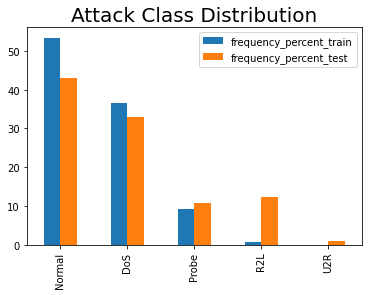

In [23]:
# Attack class bar plot

plot = attack_class_dist[['frequency_percent_train', 'frequency_percent_test']].plot(kind="bar");
plot.set_title("Attack Class Distribution", fontsize=20);

## Dummy variables

In [24]:
# To avoid the case when distict entries in categorical features dont match in the training and test ing data
print("\n=============== Unique labels in the respective features ===============\n")

dfkdd_full = pd.concat([dfkdd_train, dfkdd_test], keys=["train", "test"])
cat = ['protocol_type', 'service', 'flag']

for i in cat:
    print(i,": {}".format(dfkdd_full[i].nunique()))


=============== Unique labels in the respective features ===============

protocol_type : 3
service : 70
flag : 11


In [25]:
# No of unique values in 'service' is much greater, so dropping it
dfkdd_full.drop('service', axis = 1, inplace = True)
cat = ['protocol_type', 'flag']
    
print("\n============== Before Dummy Variable Creation ==============\n")
print("Dimensions of training data: {}".format(dfkdd_train.shape))
print("Dimensions of testing data: {}".format(dfkdd_test.shape))

dfkdd_full = pd.get_dummies(dfkdd_full, columns = cat, prefix = cat, drop_first = True)
df_train_dum = dfkdd_full.loc["train"]
df_test_dum = dfkdd_full.loc["test"]

print("\n=============== After Dummy Variable Creation ===============\n")
print("Dimensions of training data: {}".format(df_train_dum.shape))
print("Dimensions of testing data: {}".format(df_test_dum.shape))


============== Before Dummy Variable Creation ==============

Dimensions of training data: (125973, 43)
Dimensions of testing data: (22544, 43)

=============== After Dummy Variable Creation ===============

Dimensions of training data: (125973, 52)
Dimensions of testing data: (22544, 52)


In [26]:
# protocol_type Class Distribution
protocol_type_freq_train = dfkdd_train[['protocol_type']].apply(lambda x: x.value_counts())
protocol_type_freq_test = dfkdd_test[['protocol_type']].apply(lambda x: x.value_counts())
protocol_type_freq_train['frequency_percent_train'] = round((100 * protocol_type_freq_train / protocol_type_freq_train.sum()),2)
protocol_type_freq_test['frequency_percent_test'] = round((100 * protocol_type_freq_test / protocol_type_freq_test.sum()),2)

protocol_type_dist = pd.concat([protocol_type_freq_train,protocol_type_freq_test], axis=1) 
protocol_type_dist

,protocol_type,frequency_percent_train,protocol_type,frequency_percent_test
tcp,102689,81.52,18880,83.75
udp,14993,11.90,2621,11.63
icmp,8291,6.58,1043,4.63


In [27]:
# flag Class Distribution
protocol_type_freq_train = dfkdd_train[['flag']].apply(lambda x: x.value_counts())
protocol_type_freq_test = dfkdd_test[['flag']].apply(lambda x: x.value_counts())
protocol_type_freq_train['frequency_percent_train'] = round((100 * protocol_type_freq_train / protocol_type_freq_train.sum()),2)
protocol_type_freq_test['frequency_percent_test'] = round((100 * protocol_type_freq_test / protocol_type_freq_test.sum()),2)

protocol_type_dist = pd.concat([protocol_type_freq_train,protocol_type_freq_test], axis=1) 
protocol_type_dist

,flag,frequency_percent_train,flag,frequency_percent_test
SF,74945,59.49,14875,65.98
S0,34851,27.67,2013,8.93
REJ,11233,8.92,3850,17.08
RSTR,2421,1.92,669,2.97
RSTO,1562,1.24,773,3.43
S1,365,0.29,21,0.09
SH,271,0.22,73,0.32
S2,127,0.10,15,0.07
RSTOS0,103,0.08,2,0.01
S3,49,0.04,249,1.10


# Binary Classification

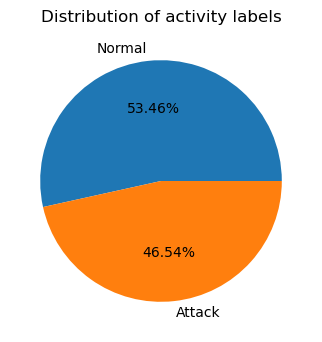

In [28]:
# pie chart distribution of normal and attack labels
plt.figure(figsize=(4,4), dpi=100)
plt.pie(dfkdd_train.activity.value_counts().values,labels=dfkdd_train.activity.value_counts().index,autopct='%0.2f%%')
plt.title("Distribution of activity labels")
plt.show()

In [29]:
pd.crosstab(dfkdd_train.activity, dfkdd_train.flag, rownames=['Activity'], colnames=['Flag'], dropna=False)

Flag,OTH,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH
Activity,,,,,,,,,,,
Attack,35,8540,1343,103,2275,34497,4,8,4,11552,269
Normal,11,2693,219,0,146,354,361,119,45,63393,2


In [30]:
pd.crosstab(dfkdd_train.activity, dfkdd_train.protocol_type, rownames=['Activity'], colnames=['Protocol'], dropna=False)

Protocol,icmp,tcp,udp
Activity,,,
Attack,6982,49089,2559
Normal,1309,53600,12434


### Some of the categorical labels seem to be highly predictive 

###  Data preperation and standardization

In [31]:
from sklearn.preprocessing import StandardScaler

In [32]:
train_dum_binary = df_train_dum.copy()
test_dum_binary = df_test_dum.copy()

In [33]:
#Handling Outliers as logistic regression is prone to them

def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.99))
    x = x.clip(lower=x.quantile(0.01))
    return x

#---------------------------------------------------------------------------

num_cols = train_dum_binary.select_dtypes(include='number').columns

train_dum_binary[num_cols]=train_dum_binary[num_cols].apply(outlier_capping)
test_dum_binary[num_cols]=test_dum_binary[num_cols].apply(outlier_capping)

In [34]:
# getting rid of features with no variance after outlier treatment

num_cols = train_dum_binary.select_dtypes(include='number').columns
num_summary = train_dum_binary[num_cols].apply(continuous_var_summary).T
constants = num_summary[num_summary.MIN == num_summary.MAX].index
constants

Index(['land', 'wrong_fragment', 'urgent', 'num_failed_logins', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'is_host_login', 'is_guest_login', 'flag_RSTOS0',
       'flag_S1', 'flag_S2', 'flag_S3', 'flag_SH'],
      dtype='object')

In [35]:
train_dum_binary.drop(constants, axis=1, inplace=True)
test_dum_binary.drop(constants, axis=1, inplace=True)

### Standardizing Data 

In [36]:
scaler = StandardScaler()
train_unscaled=train_dum_binary.copy()
test_unscaled=test_dum_binary.copy()

# ------------------------------------------------------------------------------------

scaler = StandardScaler()

num_cols = train_dum_binary.select_dtypes(include='number').columns

sc_train = scaler.fit_transform(train_dum_binary[num_cols])
sc_test = scaler.transform(test_dum_binary[num_cols])

#turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = num_cols)
sc_testdf = pd.DataFrame(sc_test, columns = num_cols)

train_dum_binary[num_cols] = sc_traindf
test_dum_binary[num_cols] = sc_test

In [37]:
train_dum_binary['activity'] = train_dum_binary['activity'].apply(lambda x: x=='Normal').astype('int32')
test_dum_binary['activity'] = test_dum_binary['activity'].apply(lambda x: x=='Normal').astype('int32')

In [38]:
train_dum_binary.corr().abs()['activity'].sort_values(ascending=False).head(15)

activity                    1.000000
flag_SF                     0.756286
same_srv_rate               0.751913
dst_host_srv_count          0.722536
dst_host_same_srv_rate      0.693803
logged_in                   0.690171
dst_host_srv_serror_rate    0.654985
dst_host_serror_rate        0.651842
serror_rate                 0.650652
flag_S0                     0.650206
srv_serror_rate             0.648289
count                       0.576444
last_flag                   0.404302
dst_host_count              0.375052
dst_bytes                   0.289517
Name: activity, dtype: float64

### Inspecting correlation 

In [39]:
correlation = train_dum_binary.corr()
correlation.to_excel('correlation.xlsx')

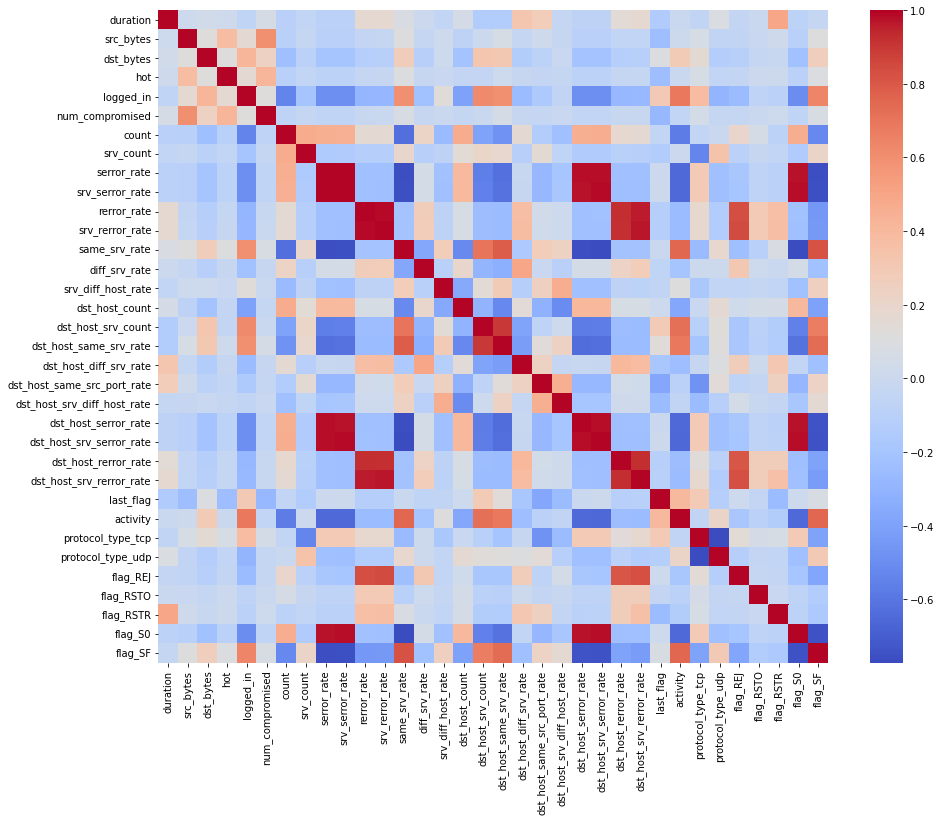

In [40]:
# Plotting correlation
plt.figure(figsize=(15, 12))
sns.heatmap(correlation, cmap='coolwarm')
plt.show()

## Feature selection using RFE

In [41]:
# Separating features (X-variables) & Y(dependent) variable into 2 separate dataframe
features = train_dum_binary[train_dum_binary.columns.difference(['activity', 'attack_class'])]
target = train_dum_binary['activity']

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Using RFE to get importance of each variable
rfe = RFE(estimator = RandomForestClassifier(random_state=42), n_features_to_select=20)
rfe.fit(features, target)

# Getting important features
rfe_cols = list(features.columns[rfe.support_])
print(rfe_cols)

['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_rerror_rate', 'dst_host_same_src_port_rate', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'dst_host_srv_serror_rate', 'flag_SF', 'last_flag', 'logged_in', 'protocol_type_tcp', 'same_srv_rate', 'src_bytes', 'srv_count', 'srv_serror_rate']


## Multi Collinearity Check - VIF

In [42]:
# High VIF means information in that variable has already been explained by other X variables present in the model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

model_param = 'activity ~ ' + ' + '.join(rfe_cols)
print(model_param)

activity ~ count + diff_srv_rate + dst_bytes + dst_host_count + dst_host_diff_srv_rate + dst_host_rerror_rate + dst_host_same_src_port_rate + dst_host_same_srv_rate + dst_host_serror_rate + dst_host_srv_count + dst_host_srv_diff_host_rate + dst_host_srv_serror_rate + flag_SF + last_flag + logged_in + protocol_type_tcp + same_srv_rate + src_bytes + srv_count + srv_serror_rate


In [43]:
# First taking all the vaiables and iteratively removing variable with higher VIF we got the final eqn as new_eqn

#dropped: dst_host_srv_serror_rate + srv_serror_rate + flag_SF + dst_host_same_srv_rate + same_srv_rate + protocol_type_tcp + 
#dst_host_serror_rate +

model_param = '''activity ~ count + diff_srv_rate + dst_bytes + dst_host_count + dst_host_diff_srv_rate + dst_host_rerror_rate + 
dst_host_same_src_port_rate + dst_host_srv_count + dst_host_srv_diff_host_rate + last_flag + logged_in + 
protocol_type_udp + src_bytes + srv_count'''

# separate the Y and X variables
y, X = dmatrices(model_param, data = train_dum_binary, return_type = 'dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# display the output
vif.sort_values('VIF', ascending=False, inplace=True)
vif.head()

,Features,VIF
11,logged_in,3.632034
1,count,3.013366
8,dst_host_srv_count,2.950362
14,srv_count,2.464710
4,dst_host_count,1.963027


In [44]:
# All the features have less than 4 VIF Factor(low Multicollinearity). using these features for model building.
vif_cols = list(set(vif.Features).difference(['Intercept']))
vif_cols.sort()
print('numbers of selected features: ', len(vif_cols))
print(vif_cols)

numbers of selected features:  14
['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_rerror_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'last_flag', 'logged_in', 'protocol_type_udp', 'src_bytes', 'srv_count']


## Modelling and Predictions

In [45]:
# get the model equation
formula_m1 = 'attack ~ ' + ' + '.join(vif_cols)
print(formula_m1)

attack ~ count + diff_srv_rate + dst_bytes + dst_host_count + dst_host_diff_srv_rate + dst_host_rerror_rate + dst_host_same_src_port_rate + dst_host_srv_count + dst_host_srv_diff_host_rate + last_flag + logged_in + protocol_type_udp + src_bytes + srv_count


In [46]:
# the model equation after dropping features with higher pvalue
import statsmodels.formula.api as smf

formula_m1 = '''activity ~ count + diff_srv_rate + dst_bytes + dst_host_count + dst_host_diff_srv_rate + dst_host_rerror_rate + 
dst_host_same_src_port_rate + dst_host_srv_count + dst_host_srv_diff_host_rate + last_flag + logged_in + protocol_type_udp + 
src_bytes + srv_count'''

# execute a model for the X variables
model1 = smf.logit( formula = formula_m1, data = train_dum_binary ).fit() 

# print the model summary stats 
print(model1.summary2())

Optimization terminated successfully.
         Current function value: 0.096433
         Iterations 11
                               Results: Logit
Model:                   Logit               Pseudo R-squared:    0.860     
Dependent Variable:      activity            AIC:                 24326.0087
Date:                    2022-09-26 10:50    BIC:                 24472.1660
No. Observations:        125973              Log-Likelihood:      -12148.   
Df Model:                14                  LL-Null:             -87016.   
Df Residuals:            125958              LLR p-value:         0.0000    
Converged:               1.0000              Scale:               1.0000    
No. Iterations:          11.0000                                            
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Inte

In [47]:
final_features = list(model1.pvalues.index.difference(['Intercept']))
print('length of final features:', len(final_features))
print(final_features)

length of final features: 14
['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_rerror_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'last_flag', 'logged_in', 'protocol_type_udp', 'src_bytes', 'srv_count']


In [48]:
trainout = pd.DataFrame(train_dum_binary['activity'])
trainout['predict_proba'] = model1.predict(train_dum_binary[final_features])
trainout.head()

,activity,predict_proba
0,1,0.810755
1,1,0.027506
2,0,0.001527
3,1,0.999971
4,1,0.999583


In [49]:
# declare empty dataframe
cm_scores = pd.DataFrame()

for iCutoff in np.arange(0, 1, 0.005):
    
    # do the predictions at the cutoff
    y_predict = np.where( trainout.predict_proba >= iCutoff, 1, 0 )
    
    # create the confusion matrix with predicted y
    cm = metrics.confusion_matrix( trainout.activity, y_predict )[::-1, ::-1]
    
    # get the sentivity + specificity at the cutoff
    Total = cm[0, 0]/cm.sum(axis = 1)[0] + cm[1, 1]/cm.sum(axis = 1)[1]
    
    # append the data row wise in the dataframe
    cm_scores = pd.concat( [cm_scores, pd.DataFrame([iCutoff, Total]).T ], axis = 0 )
    
cm_scores.columns = ['Cutoff', 'Score']
cm_scores.loc[ cm_scores.Score == cm_scores.Score.max(), 'Cutoff']

0    0.72
Name: Cutoff, dtype: float64

In [50]:
lr_train_pred = model1.predict(train_dum_binary[final_features]).map(lambda x: 1 if x >= 0.72 else 0 )
lr_test_pred = model1.predict(test_dum_binary[final_features]).map(lambda x: 1 if x >= 0.72 else 0 )

In [51]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_dum_binary['activity'], lr_train_pred))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_dum_binary['activity'], lr_test_pred))

The overall accuracy score for the Train Data is :  0.9677629333269828
The overall accuracy score for the Test Data  is :  0.907957771469127


In [52]:
print('ROC AUC score of train data:', metrics.roc_auc_score(train_dum_binary['activity'], lr_train_pred))
print('ROC AUC score of test data:', metrics.roc_auc_score(test_dum_binary['activity'], lr_test_pred))

ROC AUC score of train data: 0.9694224831705577
ROC AUC score of test data: 0.9068908369192181


In [53]:
# Getting classification metrics scores for training dataset
print(metrics.classification_report(train_dum_binary['activity'], lr_train_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     58630
           1       0.99      0.95      0.97     67343

    accuracy                           0.97    125973
   macro avg       0.97      0.97      0.97    125973
weighted avg       0.97      0.97      0.97    125973



In [54]:
# Getting classification metrics scores for testing dataset
print(metrics.classification_report(test_dum_binary['activity'], lr_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92     12833
           1       0.89      0.90      0.89      9711

    accuracy                           0.91     22544
   macro avg       0.91      0.91      0.91     22544
weighted avg       0.91      0.91      0.91     22544



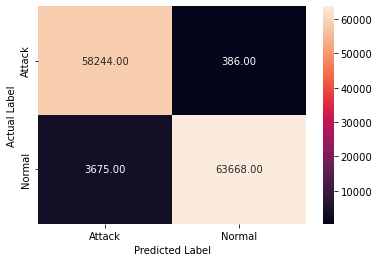

In [55]:
# confusion matrix of training dataset
confusion_matrix = metrics.confusion_matrix(train_dum_binary['activity'], lr_train_pred)
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', 
            xticklabels = ['Attack', 'Normal'], 
            yticklabels = ['Attack', 'Normal'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

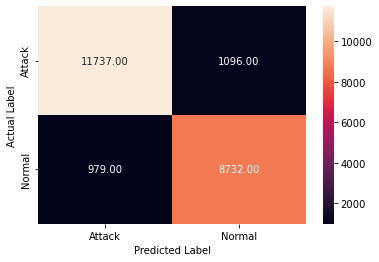

In [56]:
# confusion matrix of testing dataset
confusion_matrix = metrics.confusion_matrix(test_dum_binary['activity'], lr_test_pred)
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', 
            xticklabels = ['Attack', 'Normal'], 
            yticklabels = ['Attack', 'Normal'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [57]:
trainout = train_unscaled[final_features + ['activity', 'attack_class']]

testout = test_unscaled[final_features + ['activity', 'attack_class']]


In [58]:
lr_train_pred=lr_train_pred.apply(lambda x: 'Normal' if x==1 else 'Attack')

lr_test_pred=lr_test_pred.apply(lambda x: 'Normal' if x==1 else 'Attack')

In [65]:
trainout.loc[:,'lr_activity'] = lr_train_pred.values
testout.loc[:,'lr_activity'] = lr_test_pred.values

## A few more models

In [69]:
final_features = ['count', 'diff_srv_rate', 'dst_bytes', 'dst_host_count', 'dst_host_diff_srv_rate', 'dst_host_rerror_rate', 
                  'dst_host_same_src_port_rate', 'dst_host_srv_count', 'dst_host_srv_diff_host_rate', 'last_flag', 'logged_in', 
                  'protocol_type_udp', 'src_bytes', 'srv_count']

train_x, test_x, train_y, test_y = train_test_split(train_dum_binary[final_features], train_dum_binary['activity'], 
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [70]:
# Writing output data into excel
output = pd.ExcelWriter('Network_Intrusion_output.xlsx')

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRFClassifier
from sklearn import svm

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

In [72]:
# Different models
models = []
models.append(('LR', LogisticRegression()))
models.append(('RFC', RandomForestClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('ADABC', AdaBoostClassifier()))
models.append(('ETC', ExtraTreeClassifier()))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('XGBC', XGBRFClassifier()))

In [73]:
# evaluate each model in turn
names = []
results = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold, scoring='roc_auc', n_jobs=-1) 
    names.append(name)
    results.append(cv_results)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.993750 (0.000135)
RFC: 0.999993 (0.000003)
CART: 0.997262 (0.000365)
ADABC: 0.998992 (0.000155)
ETC: 0.995757 (0.000559)
GBC: 0.999917 (0.000027)
XGBC: 0.999819 (0.000021)


In [74]:
models_df = pd.DataFrame({'Model': names, 'Score': [round(r.mean()*100,4) for r in results]})
models_df.sort_values(by='Score', ascending=False, inplace=True, ignore_index=True)
models_df

,Model,Score
0,RFC,99.9993
1,GBC,99.9917
2,XGBC,99.9819
3,ADABC,99.8992
4,CART,99.7262
5,ETC,99.5757
6,LR,99.3750


### Random Forrest Classifier takes the cake 🎂 , going ahead with some further hyperparameter tuning 

In [75]:
param = {'n_estimators' : [400,500,600],
         'max_depth' : [20,30,40]
        }
gscv_rf = GridSearchCV(estimator = RandomForestClassifier(random_state=42), 
                     param_grid= param,
                     scoring = 'roc_auc',
                     cv = 10,
                     n_jobs = -1,
                     verbose=5).fit(train_x, train_y)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


In [76]:
gscv_rf.best_estimator_

RandomForestClassifier(max_depth=30, n_estimators=500, random_state=42)

max_depth=30, n_estimators=500, random_state=42

In [77]:
gscv_rf.best_score_

0.9999947024986959

In [78]:
rf = gscv_rf.best_estimator_
rf.fit(train_x, train_y)

# Making prediction on train and test data
rf_train_pred = rf.predict(train_x)
rf_test_pred = rf.predict(test_x)

# Calculating log loss
print("Log Loss train: ", metrics.log_loss(train_y, rf.predict_proba(train_x)))
print("Log Loss test: ", metrics.log_loss(test_y, rf.predict_proba(test_x)))

Log Loss train:  0.0014208704868755985
Log Loss test:  0.004546194206795484


In [79]:
print("Model Performance")
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(train_y, rf_train_pred))
print("AUC      : ", metrics.roc_auc_score(train_y, rf_train_pred))
print("")
print("Test Dataset")
acc_rf = metrics.accuracy_score(test_y, rf_test_pred)
print("Accuracy : ", metrics.accuracy_score(test_y, rf_test_pred))
print("AUC      : ", metrics.roc_auc_score(test_y, rf_test_pred))

Model Performance
Train Dataset
Accuracy :  1.0
AUC      :  1.0

Test Dataset
Accuracy :  0.9989151143099069
AUC      :  0.9989224977791148


In [80]:
# Getting classification metrics scores
print(metrics.classification_report(test_y, rf_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17709
           1       1.00      1.00      1.00     20083

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792



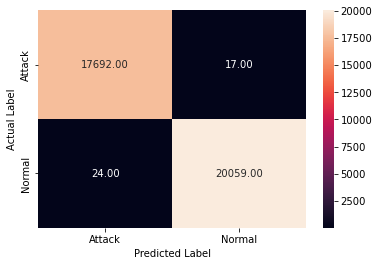

In [82]:
# confusion matrix for testing data
confusion_matrix = metrics.confusion_matrix(test_y, rf_test_pred, labels = [0,1])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', 
            xticklabels = ['Attack', 'Normal'], 
            yticklabels = ['Attack', 'Normal'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

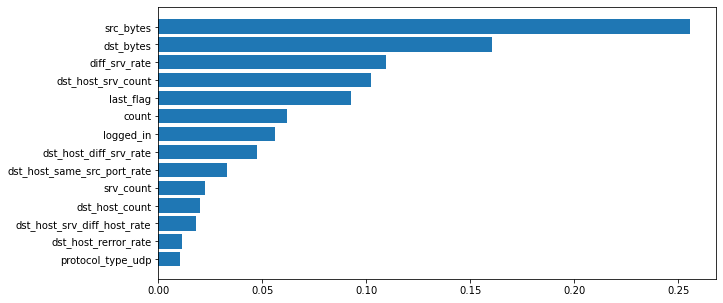

In [83]:
# Feature Impotance 
rf_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : rf.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

rf_fi.to_excel(output, 'Drivers_Binomial', startrow=2, startcol=1, index = False)
plt.figure(figsize=(10,5))
plt.barh(width = rf_fi.Importance, y = rf_fi.Features)
plt.show()

#### Evaluating model on test dataset

In [86]:
rf_testfinal_pred = rf.predict(test_dum_binary[final_features])

In [89]:
# Getting classification metrics scores
print(metrics.classification_report(test_dum_binary['activity'], rf_testfinal_pred))

              precision    recall  f1-score   support

           0       0.97      0.71      0.82     12833
           1       0.72      0.97      0.83      9711

    accuracy                           0.82     22544
   macro avg       0.84      0.84      0.82     22544
weighted avg       0.86      0.82      0.82     22544



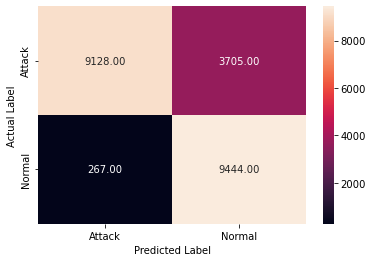

In [90]:
# confusion matrix for testing data
confusion_matrix = metrics.confusion_matrix(test_dum_binary['activity'], rf_testfinal_pred, labels = [0,1])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f', 
            xticklabels = ['Attack', 'Normal'], 
            yticklabels = ['Attack', 'Normal'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [101]:
trainout.loc[:,'rf_activity'] = rf.predict(train_dum_binary[final_features])
testout.loc[:,'rf_activity'] = rf.predict(test_dum_binary[final_features])

# Multinomial Classification

In [103]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import Normalizer, StandardScaler, LabelEncoder

traindata=train_dum_binary
testdata=test_dum_binary

In [104]:
# Getting Train and Test Datasets
train_x, test_x, train_y, test_y = train_test_split(traindata[final_features], traindata['attack_class'], 
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [105]:
# Using RandomOverSampler for rebalancing the data 
print('Original dataset shape {}'.format(Counter(train_y)))

ros = RandomOverSampler(random_state = 42, sampling_strategy = 'auto')
train_x, train_y = ros.fit_resample(train_x, train_y)

print('Oversampled dataset shape {}'.format(Counter(train_y)))

Original dataset shape Counter({'Normal': 47260, 'DoS': 32102, 'Probe': 8116, 'R2L': 668, 'U2R': 35})
Oversampled dataset shape Counter({'Normal': 47260, 'DoS': 47260, 'Probe': 47260, 'R2L': 47260, 'U2R': 47260})


In [108]:
# Different models
models = []
models.append(('LR', LogisticRegression()))
models.append(('RFC', RandomForestClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('ADABC', AdaBoostClassifier()))
models.append(('ETC', ExtraTreeClassifier()))
models.append(('GBC', GradientBoostingClassifier()))

In [109]:
# evaluate each model in turn
names = []
results = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, train_x, train_y, cv=kfold,  n_jobs=-1)
    names.append(name)
    results.append(cv_results)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.929242 (0.001684)
RFC: 0.999661 (0.000038)
CART: 0.999323 (0.000115)
ADABC: 0.600127 (0.058199)
ETC: 0.998680 (0.000302)
GBC: 0.998058 (0.000162)


In [110]:
models_df = pd.DataFrame({'Model': names, 'Score': [round(r.mean()*100,4) for r in results]})
models_df.sort_values(by='Score', ascending=False, inplace=True, ignore_index=True)
models_df

,Model,Score
0,RFC,99.9661
1,CART,99.9323
2,ETC,99.8680
3,GBC,99.8058
4,LR,92.9242
5,ADABC,60.0127


### Yet gain, Random Forrest Classifier takes the cake 🎂 , going ahead with some further hyperparameter tuning 

In [111]:
param = { 'n_estimators' : [400,500,600],
         'max_depth' : [20,30,40]
        }
gscv_rf = GridSearchCV(estimator = RandomForestClassifier(random_state=42), 
                     param_grid = param,
                     cv = 5,
                     n_jobs = -1,
                     verbose=5).fit(train_x, train_y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [112]:
gscv_rf.best_estimator_

RandomForestClassifier(max_depth=30, n_estimators=600, random_state=42)

max_depth=30, n_estimators=600, random_state=42

In [113]:
gscv_rf.best_score_

0.999678374947101

In [114]:
rf_multi = gscv_rf.best_estimator_
rf_multi.fit(train_x, train_y)

# Making prediction on train and test data
rf_train_pred = rf_multi.predict(train_x)
rf_test_pred = rf_multi.predict(test_x)

# Calculating log loss
print("Log Loss train: ", metrics.log_loss(train_y, rf_multi.predict_proba(train_x)))
print("Log Loss test: ", metrics.log_loss(test_y, rf_multi.predict_proba(test_x)))

Log Loss train:  0.00042920853888287483
Log Loss test:  0.006001992977782747


In [115]:
print("Model Performance")
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(train_y, rf_train_pred))
print("AUC      : ", metrics.roc_auc_score(train_y, rf_multi.predict_proba(train_x), multi_class = 'ovr'))
print("")
print("Test Dataset")
print("Accuracy : ", metrics.accuracy_score(test_y, rf_test_pred))
print("AUC      : ", metrics.roc_auc_score(test_y, rf_multi.predict_proba(test_x), multi_class = 'ovr'))

Model Performance
Train Dataset
Accuracy :  1.0
AUC      :  1.0

Test Dataset
Accuracy :  0.9986505080440304
AUC      :  0.9999692410866985


In [116]:
# Getting classification metrics scores for testing
print(metrics.classification_report(test_y, rf_test_pred))

              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     13825
      Normal       1.00      1.00      1.00     20083
       Probe       1.00      1.00      1.00      3540
         R2L       0.97      0.98      0.98       327
         U2R       0.67      0.71      0.69        17

    accuracy                           1.00     37792
   macro avg       0.93      0.94      0.93     37792
weighted avg       1.00      1.00      1.00     37792



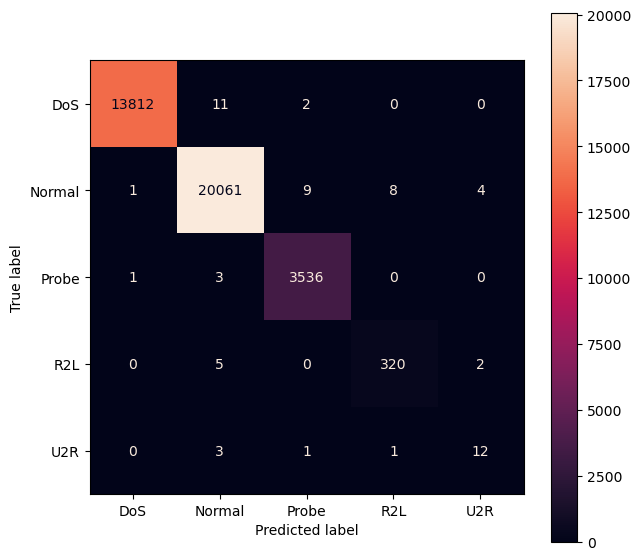

In [140]:
# Confusion Matrix for testing
fig, ax = plt.subplots(figsize=(7,7),dpi=100)
metrics.ConfusionMatrixDisplay.from_predictions(test_y, rf_test_pred, cmap='rocket', values_format='d', ax=ax);

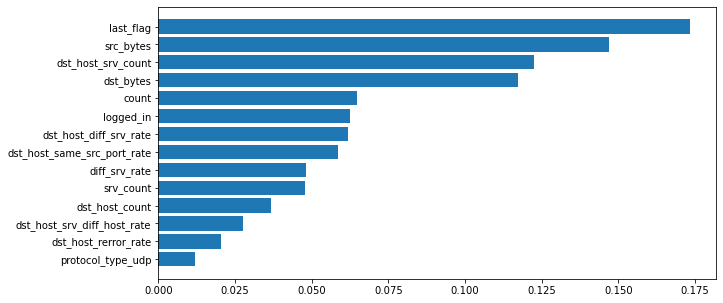

In [132]:
# Feature Impotance 
rf_fi = pd.DataFrame({'Features' : train_x.columns ,
                      'Importance' : rf_multi.feature_importances_
                     }).sort_values(by = 'Importance').reset_index(drop = True)

rf_fi.to_excel(output, 'Drivers_Multinomial', startrow=2, startcol=1, index = False)
plt.figure(figsize=(10,5))
plt.barh(width = rf_fi.Importance, y = rf_fi.Features)
plt.show()

#### Evaluating model on test dataset

In [133]:
rf_testfinal_pred = rf_multi.predict(testdata[final_features])

In [134]:
# Getting classification metrics scores for testing
print(metrics.classification_report(testdata['attack_class'], rf_testfinal_pred))

              precision    recall  f1-score   support

         DoS       0.97      0.79      0.87      7458
      Normal       0.66      0.97      0.79      9711
       Probe       0.74      0.65      0.69      2421
         R2L       0.82      0.01      0.02      2754
         U2R       0.26      0.06      0.09       200

    accuracy                           0.75     22544
   macro avg       0.69      0.50      0.49     22544
weighted avg       0.79      0.75      0.70     22544



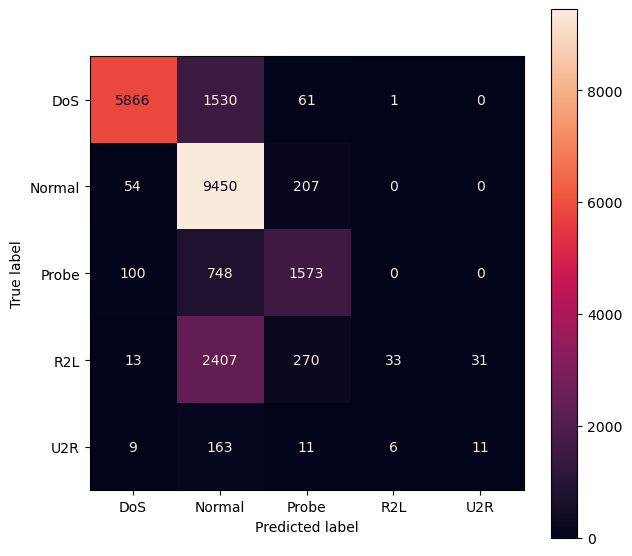

In [141]:
fig, ax = plt.subplots(figsize=(7,7), dpi=100)
metrics.ConfusionMatrixDisplay.from_predictions(testdata['attack_class'], rf_testfinal_pred, cmap='rocket', values_format='d', ax=ax);

In [136]:
trainout['rf_attack_class'] = rf_multi.predict(traindata[final_features])
testout['rf_attack_class'] = rf_multi.predict(testdata[final_features])

In [137]:
trainout.to_excel(output, 'training', startrow=2, startcol=0, index = False)
testout.to_excel(output, 'testing', startrow=2, startcol=0, index = False)

In [138]:
output.save()